# Imports

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import root_mean_squared_error as RMSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import make_scorer, r2_score
from sklearn.neighbors import KNeighborsRegressor
from gower import gower_matrix

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data preprocessing

## Import & clean base data

In [5]:
data = pd.read_csv('./Data/Clean_data.csv')

In [6]:
data.drop(columns=['Unnamed: 0', 'id'], inplace=True)
data['Locality'] = data['Locality'].astype('str')
data['Fully equipped kitchen'] = data['Fully equipped kitchen'].astype('str')
data['Fireplace'] = data['Fireplace'].astype('str')
data['Terrace'] = data['Terrace'].astype('str')
data['Garden'] = data['Garden'].astype('str')
data['Swimming pool'] = data['Swimming pool'].astype('str')
data['Furnished'] = data['Furnished'].astype('str')
data['Number of rooms'] = data['Number of rooms'].astype('int64')
data['Number of facades'] = data['Number of facades'].astype('int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10997 entries, 0 to 10996
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Locality                          10997 non-null  object 
 1   Type of property                  10997 non-null  object 
 2   Subtype of property               10997 non-null  object 
 3   Type of sale                      10997 non-null  object 
 4   Fully equipped kitchen            10997 non-null  object 
 5   Fireplace                         10997 non-null  object 
 6   Terrace                           10997 non-null  object 
 7   Garden                            10997 non-null  object 
 8   Garden area                       10997 non-null  float64
 9   Surface of the land               10997 non-null  float64
 10  Surface area of the plot of land  10997 non-null  float64
 11  Swimming pool                     10997 non-null  object 
 12  Stat

## Import and prepare FIN data

In [7]:
data_insee = pd.read_csv('./Data/INSEE_PostCode.csv', encoding='latin-1')

In [8]:
subset_columns = data_insee.columns[6:]
data_insee["PostalCodes"] = data_insee[subset_columns].apply(lambda row: row.dropna().tolist(), axis=1)
data_insee.drop(columns= data_insee.columns[6:22], inplace= True)
data_insee.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588 entries, 0 to 587
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Code INS                 588 non-null    int64 
 1   Entités administratives  588 non-null    object
 2   Langue                   588 non-null    object
 3   Région                   588 non-null    object
 4   Province                 588 non-null    object
 5   Arrondissement           588 non-null    object
 6   PostalCodes              588 non-null    object
dtypes: int64(1), object(6)
memory usage: 32.3+ KB


In [9]:
data_fin = pd.read_csv('./Data/SPF_FIN_Stat.csv', encoding= 'latin-1')

In [10]:
data_fin_postcode = pd.merge(data_fin, data_insee, how="inner", on="Code INS")
data_fin_postcode.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Entités administratives_x            562 non-null    object 
 1   Nombre d'habitants                   562 non-null    object 
 2   Revenu total net imposable           562 non-null    object 
 3   Revenu moyen par déclaration         562 non-null    float64
 4   Revenu médian par déclaration        562 non-null    float64
 5   Revenu moyen par habitant            562 non-null    float64
 6   Indice de richesse                   562 non-null    int64  
 7   Impôt d'Etat                         562 non-null    object 
 8   Taxes communales et d'agglomération  562 non-null    object 
 9   Impôt total                          562 non-null    object 
 10  Code INS                             562 non-null    int64  
 11  Entités administratives_y       

In [11]:
data_fin_postcode_exploded = data_fin_postcode.explode('PostalCodes')
data_fin_postcode_exploded.head(20)

,Entités administratives_x,Nombre d'habitants,Revenu total net imposable,Revenu moyen par déclaration,Revenu médian par déclaration,Revenu moyen par habitant,Indice de richesse,Impôt d'Etat,Taxes communales et d'agglomération,Impôt total,Code INS,Entités administratives_y,Langue,Région,Province,Arrondissement,PostalCodes
0,Aartselaar,14.752,398.803.725,46.475,34.397,27.034,124,99.799.231,4.852.750,104.651.981,11001,Aartselaar,N,RÉGION FLAMANDE,Province d'Anvers,Arrondissement d'Anvers,2630.0
1,Anvers,538.910,10.260.444.241,33.144,25.683,19.039,87,2.135.880.602,172.834.907,2.308.715.509,11002,Anvers,N,RÉGION FLAMANDE,Province d'Anvers,Arrondissement d'Anvers,2000.0
1,Anvers,538.910,10.260.444.241,33.144,25.683,19.039,87,2.135.880.602,172.834.907,2.308.715.509,11002,Anvers,N,RÉGION FLAMANDE,Province d'Anvers,Arrondissement d'Anvers,2018.0
1,Anvers,538.910,10.260.444.241,33.144,25.683,19.039,87,2.135.880.602,172.834.907,2.308.715.509,11002,Anvers,N,RÉGION FLAMANDE,Province d'Anvers,Arrondissement d'Anvers,2020.0
1,Anvers,538.910,10.260.444.241,33.144,25.683,19.039,87,2.135.880.602,172.834.907,2.308.715.509,11002,Anvers,N,RÉGION FLAMANDE,Province d'Anvers,Arrondissement d'Anvers,2030.0
1,Anvers,538.910,10.260.444.241,33.144,25.683,19.039,87,2.135.880.602,172.834.907,2.308.715.509,11002,Anvers,N,RÉGION FLAMANDE,Province d'Anvers,Arrondissement d'Anvers,2040.0
1,Anvers,538.910,10.260.444.241,33.144,25.683,19.039,87,2.135.880.602,172.834.907,2.308.715.509,11002,Anvers,N,RÉGION FLAMANDE,Province d'Anvers,Arrondissement d'Anvers,2050.0
1,Anvers,538.910,10.260.444.241,33.144,25.683,19.039,87,2.135.880.602,172.834.907,2.308.715.509,11002,Anvers,N,RÉGION FLAMANDE,Province d'Anvers,Arrondissement d'Anvers,2060.0
1,Anvers,538.910,10.260.444.241,33.144,25.683,19.039,87,2.135.880.602,172.834.907,2.308.715.509,11002,Anvers,N,RÉGION FLAMANDE,Province d'Anvers,Arrondissement d'Anvers,2100.0
1,Anvers,538.910,10.260.444.241,33.144,25.683,19.039,87,2.135.880.602,172.834.907,2.308.715.509,11002,Anvers,N,RÉGION FLAMANDE,Province d'Anvers,Arrondissement d'Anvers,2180.0


In [12]:
data_fin_postcode_exploded['PostalCodes'] = data_fin_postcode_exploded['PostalCodes'].astype('int').astype('str')

## Join FIN data on original data - clean dataset

In [13]:
data_postcodes = pd.merge(data_fin_postcode_exploded, data, how='inner', left_on='PostalCodes', right_on='Locality')
data_postcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10278 entries, 0 to 10277
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Entités administratives_x            10278 non-null  object 
 1   Nombre d'habitants                   10278 non-null  object 
 2   Revenu total net imposable           10278 non-null  object 
 3   Revenu moyen par déclaration         10278 non-null  float64
 4   Revenu médian par déclaration        10278 non-null  float64
 5   Revenu moyen par habitant            10278 non-null  float64
 6   Indice de richesse                   10278 non-null  int64  
 7   Impôt d'Etat                         10278 non-null  object 
 8   Taxes communales et d'agglomération  10278 non-null  object 
 9   Impôt total                          10278 non-null  object 
 10  Code INS                             10278 non-null  int64  
 11  Entités administratives_y   

In [14]:
data_postcodes.drop(columns= 'Entités administratives_x', inplace= True)
data_postcodes.drop(columns= 'Locality', inplace= True)
data_postcodes.drop(columns= 'Code INS', inplace= True)
data_postcodes.rename(columns={'Entités administratives_y': 'Locality'}, inplace=True)
data_postcodes.rename(columns={"Nombre d'habitants": 'N_Inhabitants'}, inplace=True)
data_postcodes.rename(columns={"Revenu total net imposable": 'Tot_taxable_income'}, inplace=True)
data_postcodes.rename(columns={"Revenu moyen par déclaration": 'Mean_income_taxunit'}, inplace=True)
data_postcodes.rename(columns={"Revenu médian par déclaration": 'Median_income_taxunit'}, inplace=True)
data_postcodes.rename(columns={"Revenu moyen par habitant": 'Mean_income_inhabitant'}, inplace=True)
data_postcodes.rename(columns={"Indice de richesse": 'Wealth_index'}, inplace=True)
data_postcodes.rename(columns={"Impôt d'Etat": 'State_tax'}, inplace=True)
data_postcodes.rename(columns={"Taxes communales et d'agglomération": 'Local_tax'}, inplace=True)
data_postcodes.rename(columns={"Impôt total": 'Tot_tax'}, inplace=True)
data_postcodes.rename(columns={"Langue": 'Language'}, inplace=True)
data_postcodes.rename(columns={"Région": 'Region'}, inplace=True)
data_postcodes.rename(columns={"Arrondissement": 'District'}, inplace=True)

In [15]:
data_postcodes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10278 entries, 0 to 10277
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   N_Inhabitants                     10278 non-null  object 
 1   Tot_taxable_income                10278 non-null  object 
 2   Mean_income_taxunit               10278 non-null  float64
 3   Median_income_taxunit             10278 non-null  float64
 4   Mean_income_inhabitant            10278 non-null  float64
 5   Wealth_index                      10278 non-null  int64  
 6   State_tax                         10278 non-null  object 
 7   Local_tax                         10278 non-null  object 
 8   Tot_tax                           10278 non-null  object 
 9   Locality                          10278 non-null  object 
 10  Language                          10278 non-null  object 
 11  Region                            10278 non-null  object 
 12  Prov

In [88]:
columns_to_convert = ["N_Inhabitants", "Tot_taxable_income", "State_tax", "Local_tax", "Tot_tax"]
data_postcodes[columns_to_convert] = data_postcodes[columns_to_convert].apply(lambda col: col.str.replace('.', '', regex=False)).astype(float)
data_postcodes['N_Inhabitants'] = data_postcodes['N_Inhabitants'].astype(int)
data_postcodes['Wealth_index'] = data_postcodes['Wealth_index'].astype(float)


AttributeError: Can only use .str accessor with string values!

## Visualise correlations

In [23]:
data_numer_fin = data_postcodes[['N_Inhabitants', 'Tot_taxable_income', 'Mean_income_taxunit', 'Median_income_taxunit', 'Mean_income_inhabitant', 'Wealth_index', 'State_tax', 'Local_tax', 'Tot_tax', 'Price']]
data_numer_prop = data_postcodes[['Garden area', 'Surface of the land', 'Surface area of the plot of land', 'Number of rooms', 'Living Area', 'Terrace area', 'Number of facades', 'Price']]

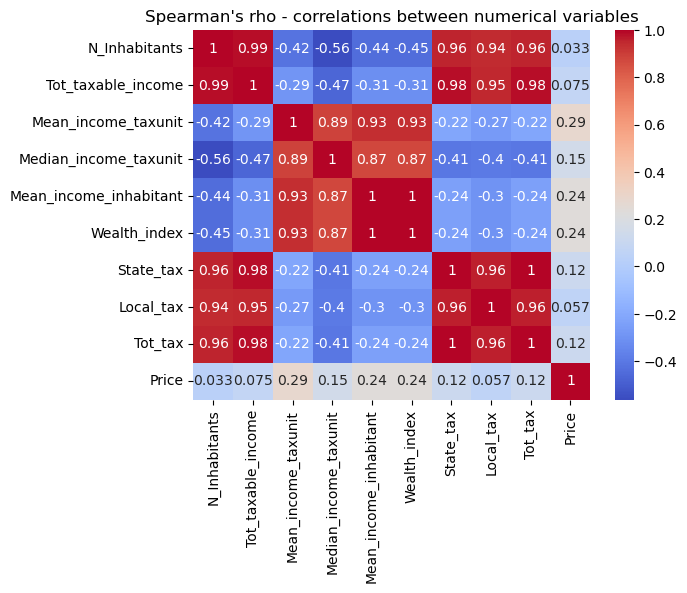

In [25]:
correlations = data_numer_fin.corr(method= 'spearman')
sns.heatmap(correlations, annot= True, cmap= 'coolwarm')

plt.title("Spearman's rho - correlations between numerical variables")

plt.show()

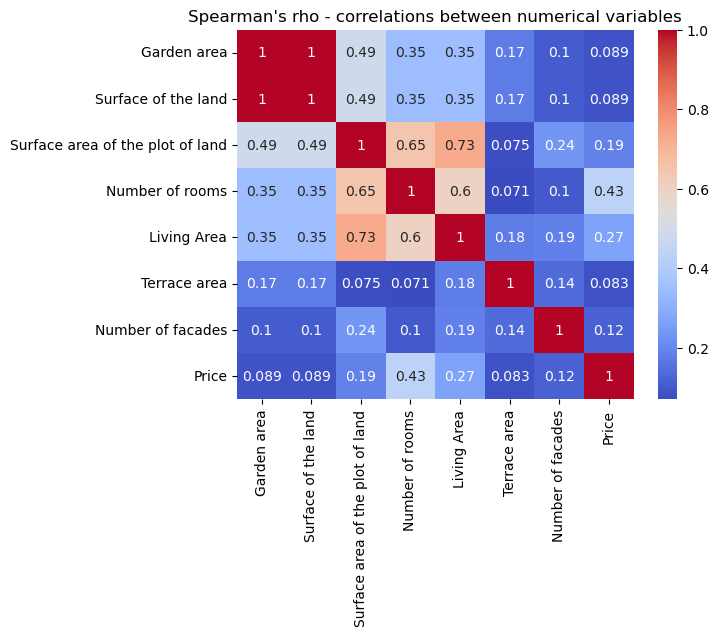

In [26]:
correlations = data_numer_prop.corr(method= 'spearman')
sns.heatmap(correlations, annot= True, cmap= 'coolwarm')

plt.title("Spearman's rho - correlations between numerical variables")

plt.show()

## PCA for dimension reduction

In [29]:
numerical_predictors = ['Surface area of the plot of land',
                        'Number of rooms',
                        'Living Area',
                        'Number of facades']
data_numerical_pred = data_postcodes[numerical_predictors]

In [30]:
X = data_numerical_pred
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

                            Feature       VIF
0  Surface area of the plot of land  1.257078
1                   Number of rooms  8.019570
2                       Living Area  7.357843
3                 Number of facades  4.875250


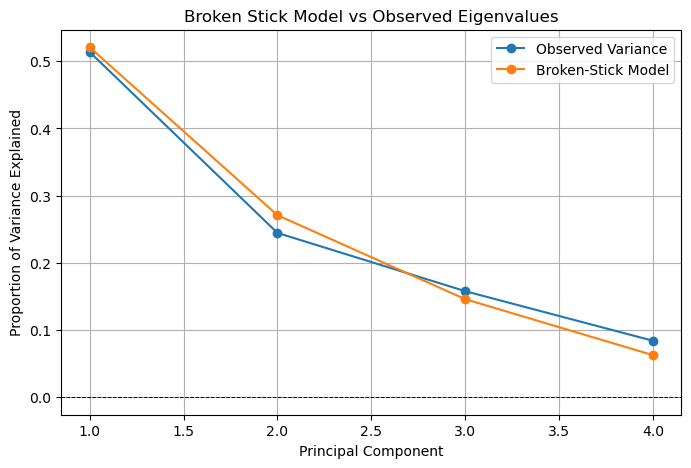

Components exceeding broken stick model:
PC3: Observed = 0.158, Broken Stick = 0.146
PC4: Observed = 0.084, Broken Stick = 0.062


In [31]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_numerical_pred)

# Perform PCA

pca = PCA()
pca.fit(scaled_data)

# Create Broken stick model to visually assess how many components to extract


def broken_stick(n_components, total_components):
    """Calculate broken-stick model values for n_components."""
    return [np.sum([1 / k for k in range(i, total_components + 1)]) / total_components for i in range(1, n_components + 1)]

n_components = len(pca.explained_variance_ratio_)

if data_numerical_pred.shape[0] <= data_numerical_pred.shape[1]:
    total_components = data_numerical_pred.shape[0] - 1
else:
    total_components = data_numerical_pred.shape[1]

broken_stick_values = broken_stick(n_components, total_components)

# Step 5: Create a DataFrame for Comparison
explained_variance = pca.explained_variance_ratio_
comparison_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(n_components)],
    'Explained Variance': explained_variance,
    'Broken-Stick Value': broken_stick_values
})

# Step 6: Plot Results
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_components + 1), explained_variance, 'o-', label='Observed Variance')
plt.plot(range(1, n_components + 1), broken_stick_values, 'o-', label='Broken-Stick Model')
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Broken Stick Model vs Observed Eigenvalues')
plt.legend()
plt.grid()
plt.show()

# Print components that exceed broken stick model
print("\
Components exceeding broken stick model:")
for i in range(n_components):
    if pca.explained_variance_ratio_[i] > broken_stick_values[i]:
        print(f"PC{i+1}: Observed = {pca.explained_variance_ratio_[i]:.3f}, Broken Stick = {broken_stick_values[i]:.3f}")


In [32]:
explained_variance_ratio = pca.explained_variance_ratio_

explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
    'Explained Variance Ratio': explained_variance_ratio,
    'Cumulative Explained Variance': np.cumsum(explained_variance_ratio)
})

explained_variance_df.to_excel('./Results-Graphs/PCA_totalData_AllPred_ExplainedVariance.xlsx', index= False)
explained_variance_df

,Principal Component,Explained Variance Ratio,Cumulative Explained Variance
0,PC1,0.513844,0.513844
1,PC2,0.244488,0.758331
2,PC3,0.157763,0.916095
3,PC4,0.083905,1.000000


In [33]:
loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                        columns=[f'PC{i+1}' for i in range(len(numerical_predictors))],
                         index = numerical_predictors )

loadings.to_excel('./Results-Graphs/PCA_totalData_AllPred_Loadings.xlsx', index= True)
loadings

,PC1,PC2,PC3,PC4
Surface area of the plot of land,0.706135,0.280472,0.646330,-0.071155
Number of rooms,0.792664,-0.417308,-0.228030,-0.381624
Living Area,0.854263,-0.266798,-0.123046,0.428964
Number of facades,0.445943,0.808736,-0.382405,-0.030728


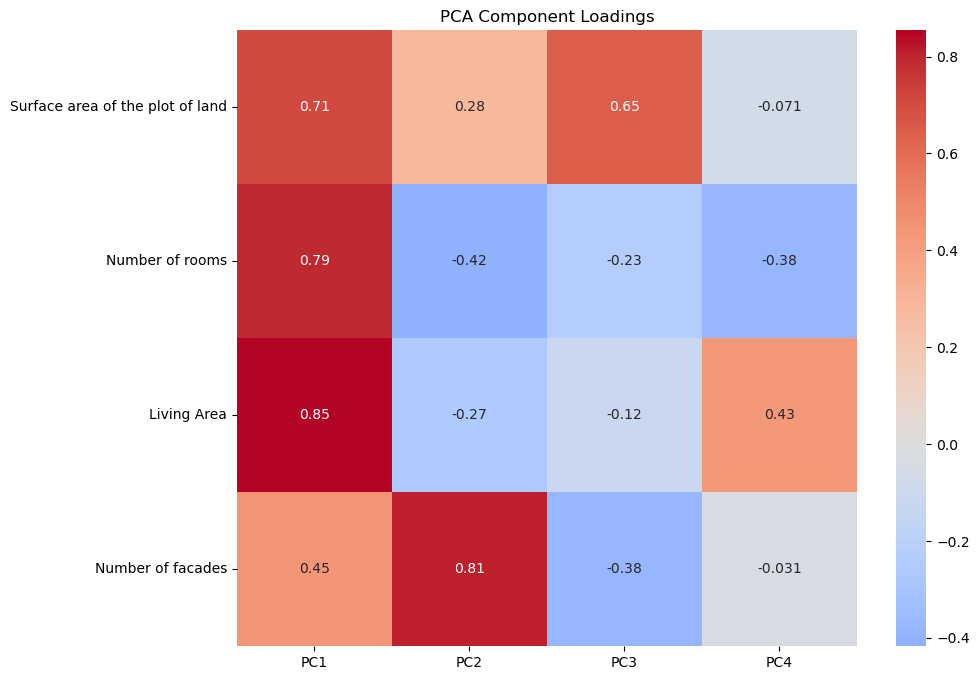

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Component Loadings')
plt.show()

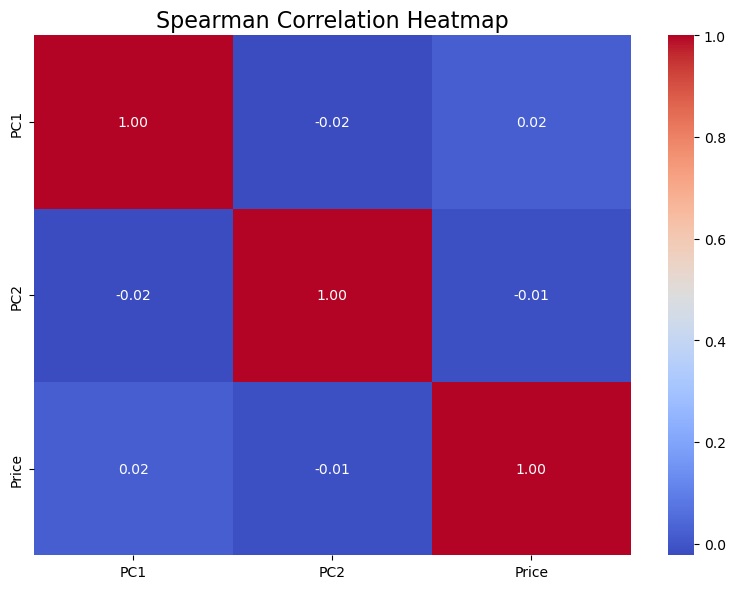

In [35]:
# Look at correlations between response variable Price and PCs

pca = PCA(n_components=2)
scores = pca.fit_transform(scaled_data)

# Create a DataFrame for the first two principal components
scores_df = pd.DataFrame(scores, columns=["PC1", "PC2"])

# Add the response variable to the DataFrame
scores_df["Price"] = data['Price']

# Calculate Spearman correlation
correlation_matrix = scores_df.corr(method="spearman")

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Spearman Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

In [36]:
data_postcodes['PC1'] = scores_df['PC1']
data_postcodes['PC2'] = scores_df['PC2']

## Select data for modelling

In [39]:
data_modelling = pd.DataFrame()
data_modelling["Mean_income_taxunit"] = data_postcodes["Mean_income_taxunit"]
data_modelling['Subtype of property'] = data_postcodes["Subtype of property"]
data_modelling["State of the building"] = data_postcodes["State of the building"]
data_modelling["PC1"] = data_postcodes["PC1"]
data_modelling["PC2"] =data_postcodes["PC2"]

## Encode/recode categories

In [49]:
data_modelling['prop_subtype_encoded'] = data_modelling['Subtype of property'].astype('category').cat.codes
data_modelling['build_state_encoded'] = data_modelling['State of the building'].astype('category').cat.codes

## X and y, train-test

In [56]:
X = data_modelling[['Mean_income_taxunit', 'prop_subtype_encoded', 'build_state_encoded', 'PC1', 'PC2']].values
y = data_postcodes['Price'].values

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Calculate Gower distance - split dataset in training and testing

In [42]:
gowermat = gower_matrix(data_modelling.values)

In [44]:
# Total number of points (matrix size is 10997 x 10997)
n_points = 10278

seed = 42
np.random.seed(seed)

# Fraction of points to select
train_fraction = 0.8

# Generate all possible indices
all_indices = np.arange(n_points)

# Randomly shuffle the indices
np.random.shuffle(all_indices)

# Select 80% of the indices for training
n_train = int(train_fraction * n_points)
train_indices = all_indices[:n_train]

# The remaining 20% are for testing
test_indices = all_indices[n_train:]

In [45]:
y = data_postcodes['Price']
y_train = y[train_indices]
y_test = y[test_indices]

In [46]:
D = gowermat[:, train_indices]
D_train, D_test = D[train_indices], D[test_indices]


In [86]:
model_metrics = pd.DataFrame(columns= ['model_name', 'R2-Adj_train', 'MAE_train', 'RMSE_train', 'MAPE_train', 'sMAPE_train', 'R2-Adj_test', 'MAE_test', 'RMSE_test', 'MAPE_test', 'sMAPE_test'])
model_metrics.to_csv('./Results-Graphs/model_metrics.csv', index= False)

In [87]:
m = pd.read_csv('./Results-Graphs/model_metrics.csv')
m

,model_name,R2-Adj_train,MAE_train,RMSE_train,MAPE_train,sMAPE_train,R2-Adj_test,MAE_test,RMSE_test,MAPE_test,sMAPE_test


In [82]:
a={}
a['model_name'] = ['1']
a['R2-Adj'] = [10]
a['MAE'] = [8]
a['RMSE'] = [9]
a['MAPE'] = [2]
a['sMAPE'] = [8]
df_a = pd.DataFrame(a)

In [85]:
m = pd.concat([m, df_a], ignore_index=True)
m

,model_name,R2-Adj,MAE,RMSE,MAPE,sMAPE
0,1,10,8,9,2,8
